In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import sklearn.model_selection as skm
import plotly.graph_objects as go





## Part 1 1 (Observational) - Generate PLS Model from Data

First we train a model off a set of 'good' batches.

#load completed batches (good batches)
#generate df_model dataframe, select  predicts 
#set up PLS model that predicts y (time) on X (input parameters, like metabolites or process signals)
#perform cross validation using n components, manually select model n_components
#generate scores (T) through PLS_1. Save to T_df dataframe
#Rearrange to X_T (wide)
#Calculate means and intervals.
#Plot

In [ ]:
class BatchEvolutionModel:
    def __init__(
        self,
        X_cols,
        batch_col='batch_id',
        time_col='batch_time_h',
        y_time_col='batch_time_h'
    ):
        """
        A reusable BEM pipeline.
        """
        if X_cols is None or len(X_cols) == 0:
            raise ValueError("X_cols must be a non-empty list of column names.")

        self.X_cols = X_cols
        self.batch_col = batch_col
        self.time_col = time_col
        self.y_time_col = y_time_col #time

        # Stage 1 (scores) state
        self.scaler_X = None #(NxJ)xK
        self.pls_scores = None  
        self.n_components = None #A
        self.score_cols = None 
        
        self.summary_df = None
        self.pls_scores_df_train = None #(NxJ)xA. dataframe. gets dmodx and T2 added on later.
        self.X_T_train = None  #Nx(JxA). converted matrix.
        self._df_model_scores = None #(NxJ)xK. dataframe
        self._X_scaled = None #(NxJ)xA. np matrix.
        self._y_scores = None
        self.cv_scores_ = None  # to store CV MSE curve

        self.T2_train = None
        self.DModX_train = None
        self.T2_limit = None
        self.DModX_limit = None
        self.T2_limit_3sd = None
        self.DModX_limit_3sd = None

        # Stage 2 (response / titer) state
        self.scaler_X2 = None
        self.pls_y = None
        self.y_titer_cols = None #titer
        self.meta_cols_for_y = None  # e.g. ['batch_id', 'solution_type']
    
    def plot_eda(
        self,
        df,
        time_col="batch_time_h",
        batch_col="batch_id",
        plot_cols=None,
        show=True,
    ):
        """
        Create one Plotly figure per measurement column.
        One line per batch (batch_col)
        """
        figs = []
        print(plot_cols)
        # Ensure data is sorted by time within each batch
        df_sorted = df.sort_values([batch_col, time_col])

        for y_col in plot_cols:
            fig = go.Figure()

            # One trace per batch
            for batch_id, df_batch in df_sorted.groupby(batch_col):
                fig.add_trace(
                    go.Scatter(
                        x=df_batch[time_col],
                        y=df_batch[y_col],
                        mode="lines+markers",
                        name=str(batch_id),
                        hovertemplate=(
                            f"{batch_col}: {batch_id}<br>"
                            f"{time_col}: %{ { 'x' } }<br>"
                            f"{y_col}: %{ { 'y' } }<extra></extra>"
                        ),
                    )
                )

            # Layout & style
            fig.update_layout(
                title=f"{y_col} vs {time_col}",
                xaxis_title=time_col,
                yaxis_title=y_col,
                legend_title=batch_col,
                template="plotly_white",
                plot_bgcolor="white",
                paper_bgcolor="white",
                width=700,
                height=450,
                margin=dict(l=60, r=30, t=60, b=50),
            )

            # Light blue grid
            fig.update_xaxes(
                showgrid=True,
                gridcolor="lightblue",
                zeroline=False,
            )
            fig.update_yaxes(
                showgrid=True,
                gridcolor="lightblue",
                zeroline=False,
            )

            if show:
                fig.show()

            figs.append(fig)

        return figs
    
    def fit_scores(
        self,
        df,
        n_splits=5,
        max_components=None,
        plot_cv=True,
        auto_select=True,
    ):
        """
        Prepare and fit the score model. Input is data in clean format (NxJ)xK columns. Find scores. Save scaled X, scores, and cv results.
        """
        df_train = df.copy()

        # 2) build df_model and y (time)
        df_model = df_train[[self.time_col, self.batch_col] + self.X_cols].copy()
        df_model = df_model.sort_values([self.batch_col, self.time_col])

        X = df_model[self.X_cols].to_numpy()
        y = df_model[[self.y_time_col]].to_numpy()  # time as y

        # 3) scale X
        self.scaler_X = StandardScaler()
        X_scaled = self.scaler_X.fit_transform(X)

        # store for later refits
        self._df_model_scores = df_model
        self._X_scaled = X_scaled
        self._y_scores = y

        # 4) choose # components via CV
        if max_components is None:
            max_components = len(self.X_cols)

        kfold = skm.KFold(n_splits, random_state=0, shuffle=True)
        pls = PLSRegression()
        param_grid = {'n_components': range(1, max_components + 1)}

        grid = skm.GridSearchCV(
            pls,
            param_grid,
            cv=kfold,
            scoring='neg_mean_squared_error'
        )
        grid.fit(X_scaled, y)

        mean_mse = -grid.cv_results_['mean_test_score']
        std_mse = grid.cv_results_['std_test_score'] / np.sqrt(n_splits)
        n_list = list(param_grid['n_components'])

        best_n = grid.best_params_['n_components']
        print(f"[BEM] CV complete. Best # of score components (by MSE): {best_n}")

        # store CV results
        self.cv_scores_ = {
            "n_components": np.array(n_list),
            "mean_mse": np.array(mean_mse),
            "std_mse": np.array(std_mse),
        }

        # 5) plot CV curve
        if plot_cv:
            plt.figure(figsize=(6, 6))
            plt.errorbar(n_list, mean_mse, yerr=std_mse, fmt='o-', capsize=5)
            plt.xlabel("# of PLS components")
            plt.ylabel("Cross-validated MSE")
            plt.title("CV MSE vs # of components (scores)")
            plt.xticks(np.arange(min(n_list), max(n_list) + 1, 1))
            plt.show()

        # 6) either auto-select or wait for user choice
        if auto_select:
            print(f"[BEM] Auto-selecting n_components = {best_n}")
            self._finalize_scores_model(n_components=best_n)
        else:
            print("[BEM] Not fitting final score model yet. "
                  "Call choose_n_components(k) after inspecting the CV plot.")

        return self

    def choose_n_components(self, n_components):
        print(f"[BEM] Fitting score model with n_components = {n_components}")
        self.finalize_scores_model(n_components=n_components)
        return self

    def finalize_scores_model(self, n_components):
        """
        Given stored X_scaled & y, fit PLS with n_components,
        compute scores (T), X_T_train, and bounds. 
        """
        if self._X_scaled is None or self._y_scores is None or self._df_model_scores is None:
            raise RuntimeError("No training data stored. Run fit_scores() first.")

        self.n_components = int(n_components)

        # fit PLS with chosen number of components
        self.pls_scores = PLSRegression(n_components=self.n_components)
        self.pls_scores.fit(self._X_scaled, self._y_scores)
        X_scaled=self._X_scaled
        T = self.pls_scores.transform(X_scaled)  #This is actually T=XW. W is rottaions.
        P = self.pls_scores.x_loadings_  #This is P
        
        self.score_cols = [f"comp_{i+1}" for i in range(self.n_components)]
        T_df = pd.DataFrame(T, columns=self.score_cols, index=self._df_model_scores.index)

        # long scores df (time, batch, comp_k)
        self.pls_scores_df_train = pd.concat(
            [self._df_model_scores[[self.time_col, self.batch_col]].reset_index(drop=True),
             T_df.reset_index(drop=True)],
            axis=1
        )
        pls_scores_df_train=self.pls_scores_df_train
        self.X_T_train = self.rearrange_scores_matrix(pls_scores_df_train)

    def rearrange_scores_matrix(self,pls_scores_df,comp_prefix='comp_'):
        """
        Convert long-format scores (batch, time, comp_k) into a batch-level matrix
        with columns like comp_1_0.0, comp_1_1.0, ...
        """
        batch_col=self.batch_col
        time_col=self.time_col
        comp_cols = [c for c in pls_scores_df.columns if c.startswith(comp_prefix)]

        long = pls_scores_df.melt(
            id_vars=[batch_col, time_col],
            value_vars=comp_cols,
            var_name='component',
            value_name='score'
        )

        wide = (
            long
            .pivot(index=batch_col, columns=['component', time_col], values='score')
            .sort_index(axis=1, level=[0, 1])
        )

        wide.columns = [f"{comp}_{t}" for (comp, t) in wide.columns]
        return wide
    
    def compute_stats(self):

        if self.X_T_train is None:
            raise RuntimeError("Need X_T_train to proceed")
        
        N, p = self._X_scaled.shape
        A = self.n_components
        X_scaled=self._X_scaled
        T = self.pls_scores.transform(X_scaled)  #This is actually T=XW. W is rottaions.
        P = self.pls_scores.x_loadings_  #This is P


        # Hotelling T²
        cov_T = np.cov(T, rowvar=False)
        cov_T_inv = np.linalg.inv(cov_T)
        self._cov_T_inv = cov_T_inv  # store for later

        T2_train = np.einsum('ij,jk,ik->i', T, cov_T_inv, T)
        self.T2_train = T2_train

        # DModX
        X_hat = T @ P.T
        E = X_scaled - X_hat
        SPE_train = np.sum(E**2, axis=1)
        DModX_train = np.sqrt(SPE_train / (p - A))
        self.DModX_train = DModX_train

        # limits (you can pick style)
        # self.T2_limit = np.quantile(T2_train, 0.99)
        # self.DModX_limit = np.quantile(DModX_train, 0.99)

        # or "mean + 3*std" style
        self.T2_limit_3sd = T2_train.mean() + 3 * T2_train.std()
        self.DModX_limit_3sd = DModX_train.mean() + 3 * DModX_train.std()

        # --- NEW: attach per-sample diagnostics to training scores df ---
        self.pls_scores_df_train["T2"] = T2_train
        self.pls_scores_df_train["DModX"] = DModX_train

        # mean/std/±3SD
        mean_row = self.X_T_train.mean(axis=0)
        std_row = self.X_T_train.std(axis=0)
        upper = mean_row + 3 * std_row
        lower = mean_row - 3 * std_row

        self.summary_df = pd.DataFrame(
            [mean_row, std_row, upper, lower],
            index=['mean', 'std', 'upper_3sd', 'lower_3sd']
        )

    def transform_new(self, df_new):
        """
        Use the trained score model to compute:
        - pls_scores_df_new (long format). Uses same X_scaler transform, as well as PLS transform as training set.
        - X_T_new (batch-level matrix, aligned to training columns)
        """
        if self.scaler_X is None or self.pls_scores is None:
            raise RuntimeError("Call fit_scores() before transform_new().")

        df_model_new = df_new[[self.time_col, self.batch_col] + self.X_cols].copy()
        df_model_new = df_model_new.sort_values([self.batch_col, self.time_col])

        X_new = df_model_new[self.X_cols].to_numpy()
        X_new_scaled = self.scaler_X.transform(X_new)

        T_new = self.pls_scores.transform(X_new_scaled)
        P = self.pls_scores.x_loadings_
        A = self.n_components
        p = X_new_scaled.shape[1]
        T2_new = np.einsum('ij,jk,ik->i', T_new, self._cov_T_inv, T_new)
        X_hat_new = T_new @ P.T
        E_new = X_new_scaled - X_hat_new
        SPE_new = np.sum(E_new**2, axis=1)
        DModX_new = np.sqrt(SPE_new / (p - A))

        T_new_df = pd.DataFrame(T_new, columns=self.score_cols, index=df_model_new.index)

        pls_scores_df_new = pd.concat(
            [df_model_new[[self.time_col, self.batch_col]].reset_index(drop=True),
            T_new_df.reset_index(drop=True)],
            axis=1
        )
        
        pls_scores_df_new["T2"] = T2_new
        pls_scores_df_new["DModX"] = DModX_new
        
        X_T_new = self.rearrange_scores_matrix(pls_scores_df_new)

        # align to training columns
        X_T_new_aligned = X_T_new.reindex(columns=self.X_T_train.columns, fill_value=np.nan)

        return pls_scores_df_new, X_T_new_aligned
    
    def plot_scores(
        self,
        components=None,
        X_T_new=None,
        new_name_prefix='NEW ',
        show=True
    ):
        """
        Plot one figure per component:
          - training batches as many thin, light lines
          - ±3·SD bounds
          - optional new batches as bold dark lines
        """
        if self.X_T_train is None or self.summary_df is None:
            raise RuntimeError("Call fit_scores() before plot_scores().")

        if components is None:
            components = self.n_components

        figs = []

        for i in range(1, components + 1):
            comp_name = f'comp_{i}'
            comp_cols = [c for c in self.X_T_train.columns if c.startswith(comp_name)]
            if not comp_cols:
                raise ValueError(f"No columns found for component {i}")

            # extract times from col names like 'comp_1_0.0'
            def extract_time(col):
                time_str = col.split(comp_name)[-1].lstrip('_')
                return float(time_str)

            times_and_cols = [(extract_time(c), c) for c in comp_cols]
            times_and_cols.sort(key=lambda x: x[0])
            times = [t for t, _ in times_and_cols]
            sorted_cols = [c for _, c in times_and_cols]

            comp_matrix_train = self.X_T_train[sorted_cols]

            mean_vals = self.summary_df.loc['mean', sorted_cols]
            upper_vals = self.summary_df.loc['upper_3sd', sorted_cols]
            lower_vals = self.summary_df.loc['lower_3sd', sorted_cols]

            fig = go.Figure()

            # training batches: light gray, thin
            for batch_id, row in comp_matrix_train.iterrows():
                fig.add_trace(
                    go.Scatter(
                        x=times,
                        y=row.values,
                        mode='lines',
                        name=str(batch_id),
                        line=dict(width=1),
                        hovertemplate='time: %{x}<br>score: %{y}<extra>' +
                                      str(batch_id) + '</extra>',
                        showlegend=False,  # keep legend from being huge
                    )
                )

            # new batches: bold, dark, thicker line & markers
            if X_T_new is not None:
                X_T_new_comp = X_T_new.reindex(columns=sorted_cols)
                for batch_id, row in X_T_new_comp.iterrows():
                    fig.add_trace(
                        go.Scatter(
                            x=times,
                            y=row.values,
                            mode='lines+markers',
                            name=f"{new_name_prefix}{batch_id}",
                            line=dict(width=3, color='darkblue'),
                            marker=dict(size=7, symbol='circle'),
                            hovertemplate='time: %{x}<br>score: %{y}<extra>' +
                                          f"{new_name_prefix}{batch_id}" + '</extra>',
                        )
                    )

            # bounds
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=upper_vals.values,
                    mode='lines',
                    name='upper (mean + 3·SD)',
                    line=dict(dash='dot'),
                    hovertemplate='time: %{x}<br>upper: %{y}<extra></extra>',
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=lower_vals.values,
                    mode='lines',
                    name='lower (mean - 3·SD)',
                    line=dict(dash='dot'),
                    hovertemplate='time: %{x}<br>lower: %{y}<extra></extra>',
                )
            )

            fig.update_layout(
                title=f"Component {i} scores over time with ±3·SD bounds",
                xaxis_title="Time (h)",
                yaxis_title=f"Component {i} score",
                legend_title="Batch / Bounds",
                plot_bgcolor="white",
                paper_bgcolor="white",
                width=700,
                height=450,
            )
            # light blue grid on a white background
            fig.update_xaxes(
                showgrid=True,
                gridcolor="lightblue",   # or "#ADD8E6"
                zeroline=False,
            )
            fig.update_yaxes(
                showgrid=True,
                gridcolor="lightblue",
                zeroline=False,
            )

            if show:
                print(f"[BEM] plotting component {i}")
                fig.show()

            figs.append(fig)

        return figs
    
    def plot_T2_trace(
        self,
        df_scores,
        batch_id,
        use_3sd_limit=True,
        title_prefix="Hotelling T²",
        show=True,
):
        """
        Plot Hotelling's T² vs time for a given batch, with a horizontal control limit.
        """


        # pick the limit
        if use_3sd_limit:
            limit = self.T2_limit_3sd
            limit_label = "T² limit (mean + 3·SD)"
        else:
            # fall back to quantile-based if you have it, otherwise use 3SD
            limit = getattr(self, "T2_limit", None) or self.T2_limit_3sd
            limit_label = "T² limit"

        # filter this batch
        mask = (df_scores[self.batch_col].astype(str) == str(batch_id))
        df_b = df_scores.loc[mask].copy()

        if df_b.empty:
            raise ValueError(f"No rows found for batch_id={batch_id!r} in df_scores.")

        df_b = df_b.sort_values(self.time_col)

        x = df_b[self.time_col].values
        y_T2 = df_b["T2"].values

        fig = go.Figure()

        # T² line for this batch
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y_T2,
                mode="lines+markers",
                name=f"Batch {batch_id} T²",
                line=dict(width=3),
                marker=dict(size=8),
                hovertemplate=(
                    f"{self.time_col}: "+"%{x}<br>"
                    "T²: %{y}<extra>"+f"{batch_id}"+"</extra>"
                ),
            )
        )

        # Horizontal limit line
        fig.add_trace(
            go.Scatter(
                x=[x.min(), x.max()],
                y=[limit, limit],
                mode="lines",
                name=limit_label,
                line=dict(dash="dash"),
                hoverinfo="skip",
            )
        )

        fig.update_layout(
            title=f"{title_prefix} – batch {batch_id}",
            xaxis_title=self.time_col,
            yaxis_title="T²",
            legend_title="Trace",
        )

        if show:
            fig.show()
        return fig
    
    def plot_DModX_trace(
            self,
            df_scores,
            batch_id,
            use_3sd_limit=True,
            title_prefix="DModX (Distance to Model)",
            show=True,
    ):
        """
        Plot DModX vs time for a given batch, with a horizontal control limit.
        """

        if use_3sd_limit:
            limit = self.DModX_limit_3sd
            limit_label = "DModX limit (mean + 3·SD)"
        else:
            limit = getattr(self, "DModX_limit", None) or self.DModX_limit_3sd
            limit_label = "DModX limit"

        mask = (df_scores[self.batch_col].astype(str) == str(batch_id))
        df_b = df_scores.loc[mask].copy()

        if df_b.empty:
            raise ValueError(f"No rows found for batch_id={batch_id!r} in df_scores.")

        df_b = df_b.sort_values(self.time_col)

        x = df_b[self.time_col].values
        y_D = df_b["DModX"].values

        fig = go.Figure()

        fig.add_trace(
            go.Scatter(
                x=x,
                y=y_D,
                mode="lines+markers",
                name=f"Batch {batch_id} DModX",
                line=dict(width=3),
                marker=dict(size=8),
                hovertemplate=(
                    f"{self.time_col}: "+"%{x}<br>"
                    "DModX: %{y}<extra>"+f"{batch_id}"+"</extra>"
                ),
            )
        )

        fig.add_trace(
            go.Scatter(
                x=[x.min(), x.max()],
                y=[limit, limit],
                mode="lines",
                name=limit_label,
                line=dict(dash="dash"),
                hoverinfo="skip",
            )
        )

        fig.update_layout(
            title=f"{title_prefix} – batch {batch_id}",
            xaxis_title=self.time_col,
            yaxis_title="DModX",
            legend_title="Trace",
        )

        if show:
            fig.show()
        return fig

    def score_contributions_for_batch_time(
        self,
        df_raw: pd.DataFrame,
        batch_id,
        time_value,
        comp_index: int = 0,
        use_abs: bool = True
    ):
        """
        Compute score contributions for a specific batch + timepoint + component. find score x loading for the specific index.
        """
        # 1) locate the row in raw df
        mask = (
            df_raw[self.batch_col].astype(str) == str(batch_id)
        ) & (
            df_raw[self.time_col] == time_value
        )
        df_match = df_raw.loc[mask]
        if df_match.empty:
            raise ValueError(
                f"No row found for batch_id={batch_id!r}, "
                f"{self.time_col}={time_value!r} in df_raw."
            )
        row = df_match.iloc[0]
        # 2) raw X -> scaled X
        x_raw = row[self.X_cols].to_numpy().reshape(1, -1)
        x_scaled = self.scaler_X.transform(x_raw)  #(1xk)
        # 3) contributions in scaled space
        w = self.pls_scores.x_rotations_      #rotations
        w_a = w[:, comp_index].reshape(1,-1) #(1xk)
        contrib_scaled = x_scaled * w_a         # (1xk)
        contrib_scaled = contrib_scaled.reshape(-1)
        contrib_series = pd.Series(contrib_scaled, index=self.X_cols)

        return contrib_series

    def plot_score_contributions_for_batch_time(
        self,
        df_raw: pd.DataFrame,
        batch_id,
        time_value,
        components: list[int] | None = None,
        top_n: int | None = 15,
        use_abs: bool = True,
        title_prefix: str = "Score contributions",
        show: bool = True,
    ):
        """
        Plot score contribution bar charts in X-space for a given
        batch + timepoint, for one or multiple components.
        """
        if components is None:
            comp_indices = list(range(self.n_components))
        else:
            comp_indices = list(components)

        figs = []

        for comp_index in comp_indices:
            contrib = self.score_contributions_for_batch_time(
                df_raw=df_raw,
                batch_id=batch_id,
                time_value=time_value,
                comp_index=comp_index,
                use_abs=use_abs,
            )

            if top_n is not None:
                contrib = contrib.head(top_n)

            x_labels = contrib.index.tolist()
            y_vals = contrib.values

            fig = go.Figure()
            fig.add_trace(
                go.Bar(
                    x=x_labels,
                    y=y_vals,
                    name=f"comp_{comp_index+1}",
                    hovertemplate="Variable: %{x}<br>Contribution: %{y}<extra></extra>",
                )
            )

            fig.update_layout(
                title=(
                    f"{title_prefix} – batch {batch_id}, "
                    f"{self.time_col}={time_value}, comp_{comp_index+1}"
                ),
                xaxis_title="Variable",
                yaxis_title=f"Contribution",
                xaxis_tickangle=-45,
                template="plotly_white",
                plot_bgcolor="white",
                paper_bgcolor="white",
                width=700, 
                height=450
            )

            fig.update_xaxes(
                showgrid=True,
                gridcolor="lightblue",   # or "#ADD8E6"
                zeroline=False,
            )
            fig.update_yaxes(
                showgrid=True,
                gridcolor="lightblue",
                zeroline=False,
            )

            if show:
                fig.show()

            figs.append(fig)

        return figs
    
    def merge_time_series_batch(self, df_XT, df_batch):
        # merge X_T_train (index=batch_id) with df_batch
        df_XT = df_XT.reset_index().rename(columns={self.batch_col: self.batch_col})
        print(self.batch_col)
        df_combined = df_XT.merge(df_batch, on=self.batch_col, how='inner')
        return df_combined
    
    def fit_response_model(
            self,
            df_batch,
            y_cols,
            meta_cols=None,
            n_splits=5,
            plot_cv=True,
            auto_select=True,
    ):
        """
        Fit a PLS model from X_T_train -> y (e.g., titer). auto select n_components feature optional.
        """
        if self.X_T_train is None:
            raise RuntimeError("Need X_train to proceed.")

        if meta_cols is None:
            meta_cols = [self.batch_col]

        self.y_titer_cols = y_cols
        self.meta_cols_for_y = meta_cols

        # merge X_T_train (index=batch_id) with df_batch
        df_XT = self.X_T_train.copy()
        df_combined = self.merge_time_series_batch(df_XT, df_batch)

        # build X2, y2
        exclude_cols = list(set(meta_cols + y_cols))
        X2_df = df_combined.drop(columns=exclude_cols, errors='ignore')
        X2 = X2_df.to_numpy()
        y2 = df_combined[y_cols].to_numpy()

        # scale X2
        self.scaler_X2 = StandardScaler()
        X2_scaled = self.scaler_X2.fit_transform(X2)

        # store for later refits
        self._X2_scaled = X2_scaled
        self._y2 = y2
        self._X2_feature_cols = X2_df.columns.tolist()

        # choose # components via CV
        pls_y = PLSRegression()
        max_n = min(X2.shape[1], 10)  # cap to avoid silly high dimensions
        param_grid_y = {'n_components': range(1, max_n + 1)}

        kfold = skm.KFold(n_splits, random_state=0, shuffle=True)
        grid_y = skm.GridSearchCV(
            pls_y,
            param_grid_y,
            cv=kfold,
            scoring='neg_mean_squared_error'
        )
        grid_y.fit(X2_scaled, y2)

        best_comp_y = grid_y.best_params_['n_components']
        print(f"[BEM] CV complete. Best # of response components (by MSE): {best_comp_y}")

        # CV curve
        mean_mse = -grid_y.cv_results_['mean_test_score']
        std_mse = grid_y.cv_results_['std_test_score'] / np.sqrt(n_splits)
        n_list = list(param_grid_y['n_components'])

        # store CV results
        self.cv_response_ = {
            "n_components": np.array(n_list),
            "mean_mse": np.array(mean_mse),
            "std_mse": np.array(std_mse),
        }

        if plot_cv:
            plt.figure(figsize=(6, 6))
            plt.errorbar(n_list, mean_mse, yerr=std_mse, fmt='o-', capsize=5)
            plt.xlabel("# of PLS components")
            plt.ylabel("Cross-validated MSE")
            plt.title("CV MSE vs # of components (response)")
            plt.show()

        if auto_select:
            print(f"[BEM] Auto-selecting response n_components = {best_comp_y}")
            self._finalize_response_model(n_components=best_comp_y)
        else:
            print("[BEM] Not fitting final response model yet. "
                "Call choose_n_response_components(k) after inspecting the CV plot.")

        return self
    
    def choose_n_response_components(self, n_components):
        """
        After running fit_response_model(..., auto_select=False),
        call this to choose how many components to use for the response PLS.

        Example:
            bem.fit_response_model(df_batch, y_cols=['titer_mg_mL'], auto_select=False)
            # inspect CV curve
            bem.choose_n_response_components(2)
        """
        print(f"[BEM] Choosing response n_components = {n_components}")
        self.finalize_response_model(n_components=n_components)
        return self

    def finalize_response_model(self, n_components):
        """
        Internal: given stored X2_scaled & y2, fit PLS with n_components
        for the response model.
        """
        if getattr(self, "_X2_scaled", None) is None or getattr(self, "_y2", None) is None:
            raise RuntimeError("No response training data stored. Run fit_response_model() first.")

        n_components = int(n_components)
        self.pls_y = PLSRegression(n_components=n_components)
        self.pls_y.fit(self._X2_scaled, self._y2)
        self._response_n_components = n_components
        print(f"[BEM] Fitted response model with n_components = {n_components}")

    def predict_response_for_new(self, X_T_new, df_batch_new=None):
        """
        Predict y (e.g., titer) for new batches using the finalized response model.
        Needs X_T_new returned by transform_new(), Expected to have index = batch_id.
        df_batch_new Batch-level metadata for new batches (e.g. ['batch_id', 'solution_type']). Should include self.batch_col so we can merge.

        Returns preds_df : DataFrame
        """
        # Ensure response model is fitted
        if self.pls_y is None or self.scaler_X2 is None:
            raise RuntimeError(
                "Response model not fitted. Call fit_response_model() and "
                "finalize_response_model()/choose_n_response_components() first."
            )

        if getattr(self, "_X2_feature_cols", None) is None:
            raise RuntimeError(
                "Training feature columns for response model are unknown. "
                "Did you run fit_response_model() successfully?"
            )
        # 1) Bring X_T_new into a DataFrame with batch_id as a column
        X_T_new_df = X_T_new.copy()

        # If index is batch_id (as in transform_new), reset it to column
        if X_T_new_df.index.name == self.batch_col or self.batch_col not in X_T_new_df.columns:
            X_T_new_df = X_T_new_df.reset_index()

        #merge
        df_combined_new=self.merge_time_series_batch(X_T_new, df_batch_new)

        
        # 3) Select same feature columns as training
        missing = set(self._X2_feature_cols) - set(df_combined_new.columns)
        if missing:
            raise ValueError(
                "The following feature columns required by the response model "
                f"are missing in the new data: {sorted(missing)}"
            )

        X2_new_df = df_combined_new[self._X2_feature_cols]

        X2_new = X2_new_df.to_numpy()


        # 4) Scale using training scaler
        X2_new_scaled = self.scaler_X2.transform(X2_new)

        # 5) Predict
        y_pred = self.pls_y.predict(X2_new_scaled)

        # 6) Build output DataFrame: index = batch_id, cols = y_cols
        batch_ids = df_combined_new[self.batch_col].values
        preds_df = pd.DataFrame(y_pred, index=batch_ids, columns=self.y_titer_cols)

        return preds_df

    def plot_predicted_vs_actual(self, df_batch_new, preds_Z, vari, show=True):
        """
        Scatter plot of predicted vs actual for a single variable.
        X = predicted, Y = actual.
        Axes forced to start at 0 with equal scaling so y=x is 45°.
        """
        # Extract actual and predicted
        print("plotting..")
        actual = df_batch_new[vari].to_numpy()
        print(actual)
        pred = preds_Z[vari].to_numpy()
        print(pred)

        # Optional: batch labels for hover if available
        if "batch_id" in df_batch_new.columns:
            batch_ids = df_batch_new["batch_id"].astype(str).to_numpy()
        else:
            batch_ids = None

        fig = go.Figure()

        # Scatter points (predicted vs actual)
        fig.add_trace(
            go.Scatter(
                x=pred,
                y=actual,
                mode="markers",
                name="Data",
                marker=dict(size=8),
                text=batch_ids,
                hovertemplate=(
                    ("batch_id: %{text}<br>" if batch_ids is not None else "") +
                    "Predicted: %{x}<br>"
                    "Actual: %{y}<extra></extra>"
                ),
            )
        )

        # ---- Set axis limits: min = 0, max = max(actual, pred) with a bit of padding ----
        min_axis = 0.0
        max_axis = float(np.nanmax([actual.max(), pred.max()]))

        # small padding so points on the edge aren't cut off
        if max_axis == min_axis:
            max_axis = min_axis + 1.0
        pad = 0.05 * (max_axis - min_axis)
        max_axis_padded = max_axis + pad

        # y = x reference line from 0 to max
        fig.add_trace(
            go.Scatter(
                x=[min_axis, max_axis_padded],
                y=[min_axis, max_axis_padded],
                mode="lines",
                name="y = x",
                line=dict(dash="dot"),
                hoverinfo="skip",
            )
        )

        # Layout & styling
        fig.update_layout(
            title=f"Predicted vs Actual: {vari}",
            xaxis_title=f"Predicted {vari}",
            yaxis_title=f"Actual {vari}",
            legend_title="",
            template="plotly_white",
            plot_bgcolor="white",
            paper_bgcolor="white",
            autosize=True,
            margin=dict(l=60, r=30, t=60, b=50),
        )

        # Light blue grid + equal aspect ratio + fixed ranges
        fig.update_xaxes(
            showgrid=True,
            gridcolor="lightblue",
            zeroline=False,
            range=[min_axis, max_axis_padded],
            scaleanchor="y",   # lock aspect so y=x is 45°
            scaleratio=1,
        )
        fig.update_yaxes(
            showgrid=True,
            gridcolor="lightblue",
            zeroline=False,
            range=[min_axis, max_axis_padded],
        )

        if show:
            fig.show()

        return fig



['titer_mg_mL', 'acetate_mM', 'glucose_g_L', 'mg_mM', 'nh3_mM', 'phosphate_mM']


[BEM] CV complete. Best # of score components (by MSE): 5


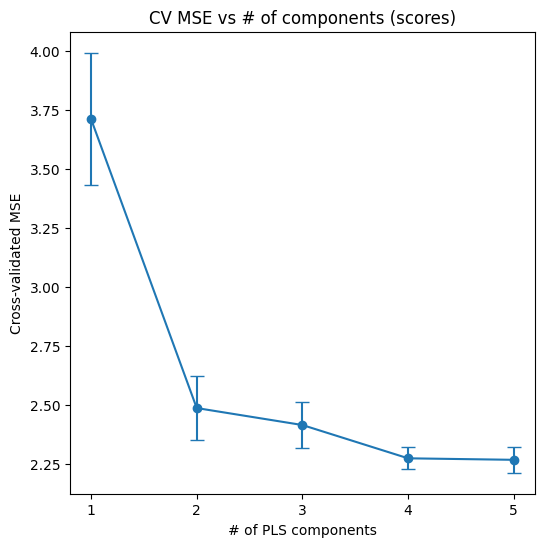

[BEM] Not fitting final score model yet. Call choose_n_components(k) after inspecting the CV plot.


In [298]:
df = pd.read_excel("synthesized_data_train.xlsx").round(3)
X_cols = ['acetate_mM', 'glucose_g_L', 'mg_mM', 'nh3_mM', 'phosphate_mM']
p_cols = ['titer_mg_mL','acetate_mM', 'glucose_g_L', 'mg_mM', 'nh3_mM', 'phosphate_mM']

bem = BatchEvolutionModel(
    X_cols=X_cols,
    batch_col='batch_id',
    time_col='batch_time_h',
    y_time_col='batch_time_h',
)
bem.plot_eda(df,time_col="batch_time_h",batch_col="batch_id",plot_cols=p_cols,show=True)
bem.fit_scores(df, n_splits=5, max_components=None, plot_cv=True, auto_select=False)

In [299]:
df 

,batch_id,batch_time_h,titer_mg_mL,acetate_mM,glucose_g_L,mg_mM,nh3_mM,phosphate_mM
0,S1_syn_001,0,0.017,44.156,0.023,11.821,17.695,12.888
1,S1_syn_001,1,0.076,52.151,0.025,11.856,20.607,14.133
2,S1_syn_001,2,0.125,59.551,0.025,11.909,22.694,15.016
3,S1_syn_001,3,0.184,63.674,0.024,11.762,24.534,15.429
4,S1_syn_001,4,0.241,67.733,0.024,11.838,25.731,16.153
...,...,...,...,...,...,...,...,...
420,S1_syn_017,20,0.536,69.692,0.029,7.416,59.185,12.932
421,S1_syn_017,21,0.514,64.577,0.032,7.418,61.843,13.922
422,S1_syn_017,22,0.492,60.421,0.035,7.619,65.788,14.354
423,S1_syn_017,23,0.452,49.985,0.043,7.869,70.558,15.603


In [300]:
#manually select components from elbow plot
bem.choose_n_components(2)
bem.compute_stats()
bem.plot_scores(components=2)

[BEM] Fitting score model with n_components = 2
[BEM] plotting component 1


[BEM] plotting component 2


[Figure({
     'data': [{'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_001</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_001',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23.0, 24.0],
               'y': {'bdata': ('XD3+BUIO/L9aUntObW/5vxWjrVuZa/' ... 'pMRTABQIRSk1Lm5AFApIAYGIrdAUA='),
                     'dtype': 'f8'}},
              {'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_002</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_002',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0,

In [301]:
#plot new batch
df_new = pd.read_excel("new_batch_incomplete_deviation.xlsx")

pls_scores_df_new, X_T_new = bem.transform_new(df_new)
bem.plot_scores(components=2, X_T_new=X_T_new)

[BEM] plotting component 1


[BEM] plotting component 2


[Figure({
     'data': [{'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_001</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_001',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23.0, 24.0],
               'y': {'bdata': ('XD3+BUIO/L9aUntObW/5vxWjrVuZa/' ... 'pMRTABQIRSk1Lm5AFApIAYGIrdAUA='),
                     'dtype': 'f8'}},
              {'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_002</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_002',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0,

In [302]:
# For a training batch:
bem.plot_T2_trace(bem.pls_scores_df_train, batch_id="S1_syn_005")
bem.plot_DModX_trace(bem.pls_scores_df_train, batch_id="S1_syn_005")

#df_new = pd.read_excel("new_batch_incomplete.xlsx")  #S1_syn_018
#df_new = pd.read_excel("new_batch_incomplete_deviation.xlsx") S1_syn_019
#df_new = pd.read_excel("new_batch_good.xlsx")  #S1_syn_013
df_new = pd.read_excel("new_batch_complete_deviation.xlsx")  #S1_syn_020
#df_new = pd.read_excel("new_batch_wrong.xlsx")  #S2_syn_021
nbatch='S1_syn_020'
''
# New evolving batch:
pls_scores_df_new, X_T_new = bem.transform_new(df_new)
# For a new evolving batch:
bem.plot_T2_trace(pls_scores_df_new, batch_id=nbatch)
bem.plot_DModX_trace(pls_scores_df_new, batch_id=nbatch)

In [303]:
# 1. Quick look at numbers
contrib = bem.score_contributions_for_batch_time(
    df_raw=df_new,
    batch_id=nbatch,
    time_value=6.0,
    comp_index=0,          # comp_1
    use_abs=True,
)
print("Top contributors:\n", contrib.head(10))

# 2. Plot contribution bar chart
bem.plot_score_contributions_for_batch_time(
    df_raw=df_new,
    batch_id=nbatch,
    time_value=6.0,
    components=None,
    top_n=10,
    use_abs=True,
    title_prefix="Score - Contributions",
)


Top contributors:
 acetate_mM      0.469280
glucose_g_L     0.192832
mg_mM          -0.650444
nh3_mM         -0.162129
phosphate_mM   -0.312040
dtype: float64


[Figure({
     'data': [{'hovertemplate': 'Variable: %{x}<br>Contribution: %{y}<extra></extra>',
               'name': 'comp_1',
               'type': 'bar',
               'x': [acetate_mM, glucose_g_L, mg_mM, nh3_mM, phosphate_mM],
               'y': {'bdata': 'kVZQEK8I3j/JEvswuK7IP8yYeWlv0OS/kqw596TAxL9ZBsMKdvjTvw==', 'dtype': 'f8'}}],
     'layout': {'height': 450,
                'paper_bgcolor': 'white',
                'plot_bgcolor': 'white',
                'template': '...',
                'title': {'text': 'Score - Contributions – batch S1_syn_020, batch_time_h=6.0, comp_1'},
                'width': 700,
                'xaxis': {'gridcolor': 'lightblue',
                          'showgrid': True,
                          'tickangle': -45,
                          'title': {'text': 'Variable'},
                          'zeroline': False},
                'yaxis': {'gridcolor': 'lightblue',
                          'showgrid': True,
                          'title'

Adding Batch Level Data

In [304]:
#input new batches (timepoint data). convert to wide form. add on batch level columns. Predict on PLS2.

#plot prediccted vs actual.

batch_id
[BEM] CV complete. Best # of response components (by MSE): 6


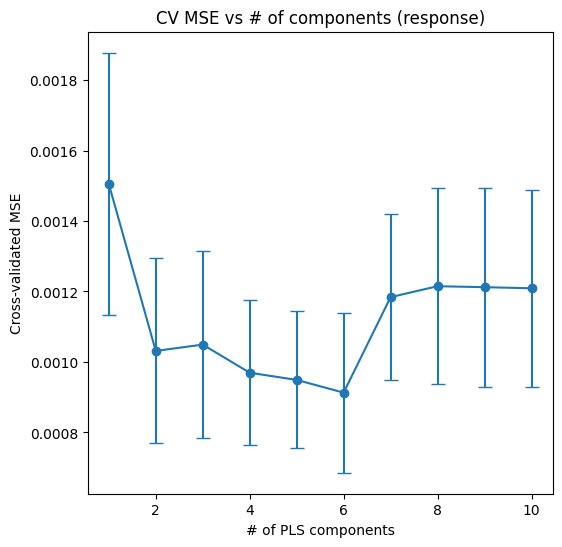

[BEM] Not fitting final response model yet. Call choose_n_response_components(k) after inspecting the CV plot.


In [305]:
#merge scores df X_T_df with batch level info (1 per batch) to predict titer.
df_batch=pd.read_excel("batch_level_data_train.xlsx")

bem.fit_response_model(
    df_batch=df_batch,
    y_cols=['titer_mg_mL'],
    meta_cols=['batch_id', 'final_weight','temp_processing'],
    n_splits=5,
    plot_cv=True,
    auto_select=False,
)



In [306]:
bem.choose_n_response_components(2)
df_test = pd.read_excel("synthesized_data_test.xlsx")
pls_scores_df_new, X_T_new = bem.transform_new(df_test)
df_batch_test=pd.read_excel("batch_level_data_test.xlsx")

preds_Z = bem.predict_response_for_new(X_T_new, df_batch_test)
bem.plot_predicted_vs_actual(df_batch_test, preds_Z, vari='titer_mg_mL')

[BEM] Choosing response n_components = 2
[BEM] Fitted response model with n_components = 2
batch_id
plotting..
[0.3824345  0.40587567 0.45282889 0.43101059 0.41050601 0.40765816
 0.42602906 0.41576193 0.38797645 0.38810997]
[0.46207587 0.42779372 0.42221291 0.43958472 0.42759993 0.43551253
 0.43179189 0.4466818  0.44286121 0.43165645]


In [307]:
df_batch_test

,batch_id,dilution_effect,final_weight,temp_processing,titer_mg_mL
0,S1_syn_test_001,1.003891,2.843137,31.20,0.382434
1,S1_syn_test_002,1.014689,2.745098,31.76,0.405876
2,S1_syn_test_003,1.120752,3.235294,30.64,0.452829
3,S1_syn_test_004,1.055976,2.843137,30.60,0.431011
4,S1_syn_test_005,0.954426,2.647059,31.92,0.410506
5,S1_syn_test_006,1.029337,2.745098,31.98,0.407658
6,S1_syn_test_007,1.065073,3.235294,30.08,0.426029
7,S1_syn_test_008,0.977041,3.137255,31.54,0.415762
8,S1_syn_test_009,1.018438,2.941176,31.58,0.387976
9,S1_syn_test_010,0.921761,2.843137,31.02,0.388110


In [282]:
preds_Z

,titer_mg_mL
S1_syn_test_001,0.462076
S1_syn_test_002,0.427794
S1_syn_test_003,0.422213
S1_syn_test_004,0.439585
S1_syn_test_005,0.427600
S1_syn_test_006,0.435513
S1_syn_test_007,0.431792
S1_syn_test_008,0.446682
S1_syn_test_009,0.442861
S1_syn_test_010,0.431656


In [ ]:
plot_predicted_vs_actual(df_batch_new, preds_Z, vari="titer_mg_ml")

,batch_time_h,batch_id,comp_1,comp_2,T2,DModX
0,0,S1_syn_test_001,-1.806539,-1.274665,3.270085,0.520500
1,1,S1_syn_test_001,-1.774020,-0.854089,2.134233,0.457015
2,2,S1_syn_test_001,-1.554358,-0.410965,1.162374,0.423178
3,3,S1_syn_test_001,-1.538756,0.234438,1.004589,0.403733
4,4,S1_syn_test_001,-1.262696,0.703244,1.233376,0.407519
...,...,...,...,...,...,...
245,20,S1_syn_test_010,1.801997,-0.222584,1.346267,0.588894
246,21,S1_syn_test_010,2.008101,-0.406551,1.798131,0.812930
247,22,S1_syn_test_010,2.325923,-0.037197,2.144136,1.197031
248,23,S1_syn_test_010,2.364910,0.180311,2.254451,1.792871


In [70]:
X_T_new

,comp_1_0,comp_1_1,comp_1_2,comp_1_3,comp_1_4,comp_1_5,comp_1_6,comp_1_7,comp_1_8,comp_1_9,...,comp_2_15,comp_2_16,comp_2_17,comp_2_18,comp_2_19,comp_2_20,comp_2_21,comp_2_22,comp_2_23,comp_2_24
batch_id,,,,,,,,,,,,,,,,,,,,,
S1_syn_test_001,-1.806539,-1.774020,-1.554358,-1.538756,-1.262696,-1.133602,-1.156769,-0.945874,-0.741148,-0.312400,...,0.995656,0.675290,0.470231,0.503864,0.295690,0.263248,0.167894,-0.130817,-0.246955,-0.258066
S1_syn_test_002,-1.447733,-1.450128,-1.623850,-1.614307,-1.656663,-1.458531,-1.336963,-1.198879,-0.959923,-0.547832,...,0.803263,0.682503,0.512936,0.359452,0.340264,0.282856,0.007736,-0.157795,0.031248,0.030475
S1_syn_test_003,-1.514597,-1.614908,-1.678218,-1.602425,-1.549914,-1.464084,-1.324297,-1.110657,-0.982052,-0.639156,...,0.331115,0.329031,0.196195,0.129327,-0.266737,-0.209036,-0.318262,-0.600490,-0.654557,-0.756872
S1_syn_test_004,-1.997050,-2.192479,-2.241672,-2.309707,-2.241677,-1.907684,-1.579184,-1.652506,-1.342361,-0.945891,...,1.124806,1.091822,1.079143,0.736759,0.899790,0.685230,0.530562,0.678983,0.821202,0.941045
S1_syn_test_005,-2.056994,-2.252933,-2.119602,-2.102255,-1.876047,-1.844224,-1.532861,-1.216335,-1.106200,-0.813426,...,0.576900,0.448606,0.277332,-0.046540,-0.238348,-0.178635,-0.354650,-0.381985,-0.616534,-0.412278
S1_syn_test_006,-1.496477,-1.485881,-1.485233,-1.365011,-1.236392,-1.168703,-0.937487,-0.874604,-0.649082,-0.439659,...,0.232800,0.235311,0.106185,0.137911,-0.125168,0.063466,0.057539,-0.100029,-0.113030,-0.139622
S1_syn_test_007,-1.625000,-1.629336,-1.511778,-1.473214,-1.390299,-1.320003,-0.996036,-0.871523,-0.876933,-0.816579,...,0.608087,0.488048,-0.075996,-0.069982,-0.219389,-0.136813,-0.223622,-0.382158,-0.482666,-0.597780
S1_syn_test_008,-1.690856,-1.634809,-1.698072,-1.792999,-1.778537,-1.564769,-1.328807,-1.330548,-1.106776,-0.851877,...,0.919563,0.789114,0.500515,0.356307,0.458414,0.274332,0.141686,0.212588,0.115301,0.235597
S1_syn_test_009,-1.454804,-1.406755,-1.518901,-1.544119,-1.358745,-1.287041,-0.933003,-0.899407,-0.612721,-0.415936,...,0.068199,-0.207167,-0.348072,-0.559790,-0.527585,-0.861058,-0.963144,-0.982606,-0.965045,-0.860894


In [ ]:
# Look at the CV plot, then:
bem.choose_n_response_components(2)
df_new = pd.read_excel("new_batch_good.xlsx")  #S1_syn_013

df_new = pd.read_excel("new_batch_good.xlsx")  #S1_syn_013


pls_scores_df_new, X_T_new = bem.transform_new(df_new)
preds_Z = bem.predict_response_for_new(X_T_new, df_batch_new=df_batch)
preds_Z


[BEM] Choosing response n_components = 2
[BEM] Fitted response model with n_components = 2
test
X_T_new_df
     batch_id  comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
0  S1_syn_013 -1.570822  -1.60232 -1.605041 -1.561932 -1.407448  -1.33255   

   comp_1_6  comp_1_7  comp_1_8  ...  comp_2_15  comp_2_16  comp_2_17  \
0 -1.439953 -1.114923 -1.022546  ...   0.971556   0.702066   0.431481   

   comp_2_18  comp_2_19  comp_2_20  comp_2_21  comp_2_22  comp_2_23  comp_2_24  
0    0.61165   0.338037   0.438082   0.481759   0.217686   0.462279   0.327521  

[1 rows x 51 columns]
df_combined_new
     batch_id  comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
0  S1_syn_013 -1.570822  -1.60232 -1.605041 -1.561932 -1.407448  -1.33255   

   comp_1_6  comp_1_7  comp_1_8  ...  comp_2_19  comp_2_20  comp_2_21  \
0 -1.439953 -1.114923 -1.022546  ...   0.338037   0.438082   0.481759   

   comp_2_22  comp_2_23  comp_2_24  dilution_effect  final_weight  \
0   0.217686   0.46

,titer_mg_mL
S1_syn_013,0.407949


### additional steps

Include 'deviation' batch. DONE

Finish the prediction portion for new batch.

Include DModX or Hotellings squared.

Include Time difference samples (interpolation?)

## Batch in Progress

In [ ]:

#load completed batches (good batches)
#generate df_model, and X
#select model n_componenents
#generate scores (T) through PLS_1
#convert to T_df
#Rearrange to X_T
#Calculate means and intervals.
#Plot

#load incomplete batch.
#generate df_model
#generate scores (T) through PLS_1.
#convert to T_df
#Rearrange to X_T
#Plot in conjunction to evaluate the BEM current.



i want to sum up matrices and their pls attributes.
X_scaled = X
we do pls.fit on X_scaled and y_scaled
W* is the projevtion matrix and is pls.rotations_
T is the scores and is X*W (projected X).
P is the loadings, and is pls.x_loadings_

In [160]:
zz=np.array([1,2,3,34,4])
zz.reshape(-1)

array([ 1,  2,  3, 34,  4])